In [25]:
from datetime import datetime
from pathlib import Path
import glob
import os
import geoutils as gu
import xdem
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
import pandas as pd
import altair as alt
from pprint import pprint
from rasterio.enums import Resampling
import copy
import json 


# Inputs

If you use the arg, you must run from CLI like this

```
HSFM_GEOMORPH_INPUT_FILE='inputs/mazama_inputs.json' jupyter nbconvert --execute --to html dem-analysis/mt_baker_mass_wasted/xdem.ipynb  --output outputs/xdem_mazama.html
```

In [26]:
# json_file_path = 'inputs/coleman_inputs.json'
# Or set an env arg:
json_file_path = os.environ['HSFM_GEOMORPH_INPUT_FILE']

In [27]:
with open(json_file_path, 'r') as j:
     params = json.loads(j.read())

In [28]:
VALLEY_BOUNDS_NAME = params["inputs"]["valley_name"]
dems_path = params["inputs"]["dems_path"]
gcas_polygon_file = params["uncertainty"]["gcas_polygon_file"]
valley_bounds_file = params["inputs"]["valley_bounds_file"]
plot_output_dir = params["inputs"]["plot_output_dir"]
output_file = params["inputs"]["uncertainty_file"]
output_file_largerarea = params["inputs"]["uncertainty_file_largearea"]
TO_DROP = params["inputs"]["TO_DROP"]
TO_DROP_LARGERAREA = params["inputs"]["TO_DROP_LARGER_AREA"]
TO_COREGISTER = params["inputs"]["TO_COREGISTER"]
DATE_FILE_FORMAT = params['inputs']['strip_time_format']
FILTER_OUTLIERS = params['inputs']['FILTER_OUTLIERS']
SIMPLE_FILTER = params['inputs']['SIMPLE_FILTER']
simple_filter_threshold = params['inputs']['simple_filter_threshold']

reference_dem_date = datetime.strptime(
    params['inputs']['reference_dem_date'], 
    DATE_FILE_FORMAT
)

RUN_LARGERAREA = params['inputs']['RUN_LARGER_AREA']

VARIOGRAM_SUBSAMPLE = params["uncertainty"]["VARIOGRAM_SUBSAMPLE"]
VARIOGRAM_N_VARIOGRAMS = params["uncertainty"]["VARIOGRAM_N_VARIOGRAMS"]
PARALLELISM = params["uncertainty"]["PARALLELISM"]
XSCALE_RANGE_SPLIT = params["uncertainty"]["XSCALE_RANGE_SPLIT"]
MAX_LAG = params["uncertainty"]["MAX_LAG"]
RESAMPLING_RES = params["uncertainty"]["RESAMPLING_RES"]

In [29]:
if not os.path.exists(plot_output_dir):
    os.makedirs(plot_output_dir, exist_ok=True)

# Get DEM file paths

In [30]:
dem_fn_list = glob.glob(os.path.join(dems_path, "*.tif"))
dem_fn_list = sorted(dem_fn_list)

if RUN_LARGERAREA:
    dem_fn_list = [f for f in dem_fn_list if Path(f).stem not in TO_DROP_LARGERAREA]
else:
    dem_fn_list = [f for f in dem_fn_list if Path(f).stem not in TO_DROP]
dem_fn_list

['/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/1970_09_29.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/1977_09_27.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/1979_10_06.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/1987_08_21.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/1990_09_05.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/1991_09_09.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/2013_09_13.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/2015_09_01.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/2019_10_11.tif']

In [31]:
datetimes = [datetime.strptime(Path(f).stem, DATE_FILE_FORMAT) for f in dem_fn_list]
datetimes

[datetime.datetime(1970, 9, 29, 0, 0),
 datetime.datetime(1977, 9, 27, 0, 0),
 datetime.datetime(1979, 10, 6, 0, 0),
 datetime.datetime(1987, 8, 21, 0, 0),
 datetime.datetime(1990, 9, 5, 0, 0),
 datetime.datetime(1991, 9, 9, 0, 0),
 datetime.datetime(2013, 9, 13, 0, 0),
 datetime.datetime(2015, 9, 1, 0, 0),
 datetime.datetime(2019, 10, 11, 0, 0)]

# Open Valley Bounds Geometry

In [32]:
valley_bounds = gu.Vector(valley_bounds_file)
uncertainty_valley_bounds_vect = valley_bounds.query(f"name == '{VALLEY_BOUNDS_NAME}' and purpose=='uncertainty'")
uncertainty_valley_bounds_vect.ds

,id,name,purpose,geometry
2,None,Coleman,uncertainty,"POLYGON ((586481.720 5404148.278, 586481.720 5..."


# Create DEMCollection

In [33]:
demcollection_uncertainty = xdem.DEMCollection.from_files(
    dem_fn_list, 
    datetimes, 
    reference_dem_date, 
    uncertainty_valley_bounds_vect, 
    RESAMPLING_RES,
    Resampling.cubic
)

In [34]:

if TO_COREGISTER:
    for i in range(0, len(demcollection_uncertainty.dems)-1):
        early_dem = demcollection_uncertainty.dems[i]
        late_dem = demcollection_uncertainty.dems[i+1]

        nuth_kaab = xdem.coreg.NuthKaab()
        # Order with the future as reference
        nuth_kaab.fit(late_dem.data, early_dem.data, transform=late_dem.transform)

        # Apply the transformation to the data (or any other data)
        aligned_ex = nuth_kaab.apply(early_dem.data, transform=early_dem.transform)

        print(F"For DEM {early_dem.datetime}, transform is {nuth_kaab.to_matrix()}")

        early_dem.data = np.expand_dims(aligned_ex, axis=0)

In [35]:
_ = demcollection_uncertainty.subtract_dems_intervalwise()

# Plot dDEMs

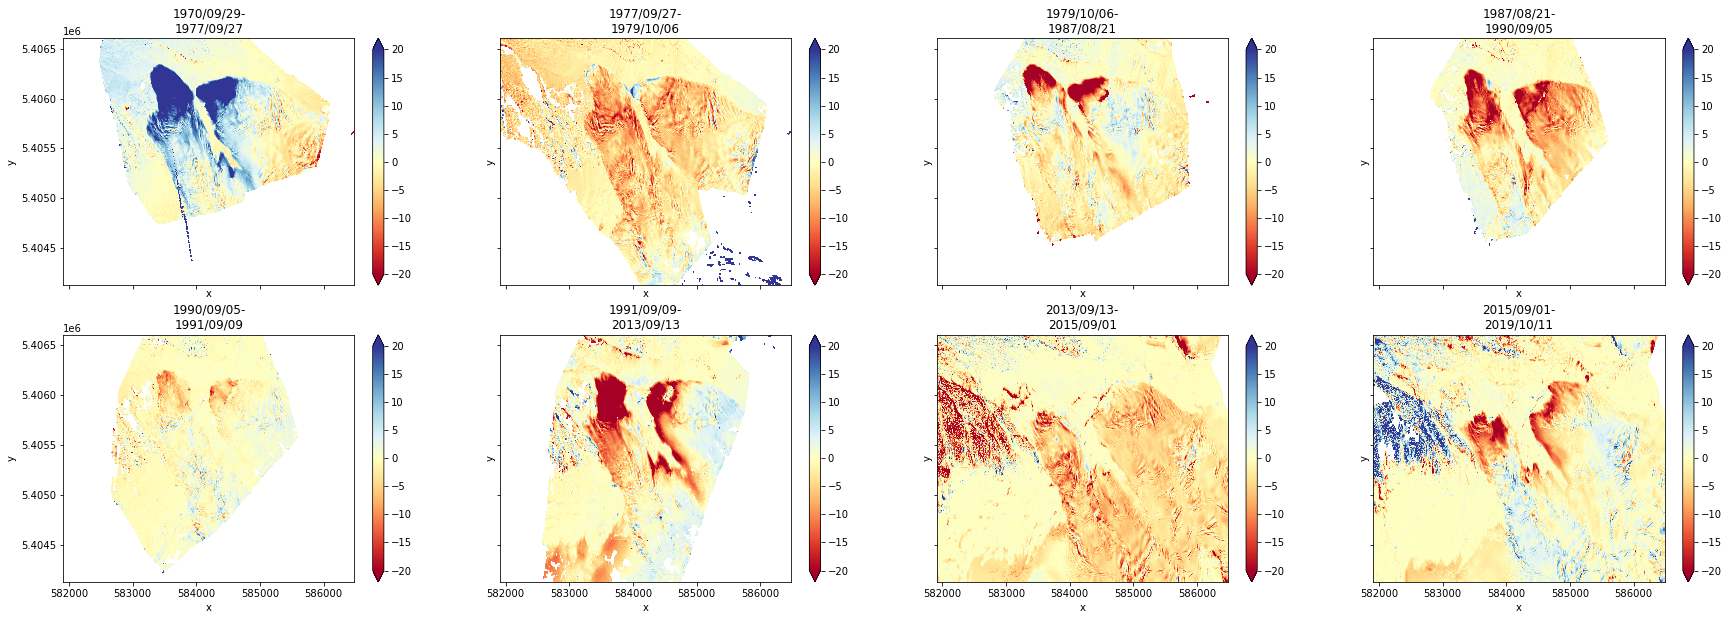

In [36]:
fig, axes = demcollection_uncertainty.plot_ddems(figsize=(30, 10), vmin=-20, vmax=20, interpolation = "none")
fig.savefig(os.path.join(plot_output_dir, "dod_gallery.png"))
plt.show()

# Calculate Uncertainty

## Open ground control polygons

In [37]:
gcas_vector = gu.Vector(gcas_polygon_file)

## Define function to perform an uncertainty analysis:
* Plot ground control area DH
* Sample dataset and plot empirical variogram
* Fit spherical model and plot empirical variogram + fitted model
* Print comprehensive statistics

In [38]:
def uncertainty_analysis(
    dh,
    ground_control_vector,
    subsample = None,
    n_variograms = None,
    xscale_range_split = None,
    ylim = None,
    maxlag = None,
    parallelism = 1
):
    figs = []

    gcas_mask = ground_control_vector.create_mask(dh)
    # Masked array containing all data
    all_values_masked = dh.data.copy()
    all_values = all_values_masked.filled(np.nan)
    # Masked array that we set to only contain data in stable areas (ground control areas)
    stable_values_masked = dh.data.copy()
    stable_values_masked.mask = np.ma.mask_or(stable_values_masked.mask, ~gcas_mask)
    stable_values = stable_values_masked.filled(np.nan)
    
    plt.figure(figsize=(4, 3))
    cmap = copy.copy(matplotlib.cm.get_cmap("RdYlBu"))
    cmap.set_bad('grey',1.)
    
    # maybe plot something else here?
    _ = plt.gca().imshow(stable_values_masked.squeeze(),cmap=cmap, vmin=-4, vmax=4)
    plt.gca().set_title('Elevation differences (m)')
    figs.append(plt.gcf())

    if FILTER_OUTLIERS:
        if SIMPLE_FILTER:
            stable_values_filt = np.where(np.abs(stable_values) < simple_filter_threshold, stable_values, np.nan)
            all_values_filt = np.where(np.abs(all_values) < simple_filter_threshold, all_values, np.nan)
        else:
            low = np.nanmedian(all_values) - 4*xdem.spatialstats.nmad(all_values)
            high = np.nanmedian(all_values) + 4*xdem.spatialstats.nmad(all_values)
            stable_values_filt = np.where(stable_values < high, stable_values, np.nan)
            stable_values_filt = np.where(stable_values_filt > low, stable_values_filt, np.nan)
            all_values_filt = np.where(all_values < high, all_values, np.nan)
            all_values_filt = np.where(all_values_filt > low, all_values_filt, np.nan)
    else:
        stable_values_filt = stable_values
        all_values_filt = all_values

    df = xdem.spatialstats.sample_empirical_variogram(
        values=stable_values_filt,
        gsd=dh.res[0],
        subsample=subsample,
        n_jobs=parallelism,
        n_variograms=n_variograms,
        maxlag=maxlag
    )
    
    if ylim:
        xdem.spatialstats.plot_vgm(
            df,
            xscale_range_split=xscale_range_split,
            ylim=ylim
        )
    else:
        xdem.spatialstats.plot_vgm(
            df,
            xscale_range_split=xscale_range_split
        )
    figs.append(plt.gcf())
    plt.show()
    fun, params = xdem.spatialstats.fit_sum_model_variogram(['Sph'], empirical_variogram=df)
    if ylim:
        xdem.spatialstats.plot_vgm(
            df,
            list_fit_fun=[fun],
            list_fit_fun_label=['Single-range model'],
            xscale_range_split=xscale_range_split,
            ylim=ylim
        )
    else:
        xdem.spatialstats.plot_vgm(
            df,
            list_fit_fun=[fun],
            list_fit_fun_label=['Single-range model'],
            xscale_range_split=xscale_range_split
        )
    figs.append(plt.gcf())
    plt.show()

    results_dict = {
        "Range": params[0],
        "Sill": params[1],
        "Interval": dh.interval,
        "NMAD": xdem.spatialstats.nmad(stable_values_filt),
        "Mean": float(np.nanmean(stable_values_filt)),
        "Median": float(np.nanmedian(stable_values_filt)),
        "RMSE": xdem.spatialstats.rmse(stable_values_filt),
        "StdDev": float(np.nanstd(stable_values_filt)),
        "Max": float(np.nanmax(stable_values_filt)),
        "Min": float(np.nanmin(stable_values_filt)),
        "Count of stable pixels": np.count_nonzero(~np.isnan(stable_values_filt)),
        "Count of all pixels": np.count_nonzero(~np.isnan(all_values_filt)),
        "Outlier lower limit": (-simple_filter_threshold if SIMPLE_FILTER else low) if FILTER_OUTLIERS else np.nan,
        "Outlier upper limit": (simple_filter_threshold if SIMPLE_FILTER else high) if FILTER_OUTLIERS else np.nan,

        "pre-filter": {            
            "NMAD": xdem.spatialstats.nmad(stable_values),
            "Mean": float(np.nanmean(stable_values)),
            "Median": float(np.nanmedian(stable_values)),
            "RMSE": xdem.spatialstats.rmse(stable_values),
            "StdDev": float(np.nanstd(stable_values)),
            "Max": float(np.nanmax(stable_values)),
            "Min": float(np.nanmin(stable_values)),
            "Count of stable pixels": np.count_nonzero(~np.isnan(stable_values)),
            "Count of all pixels": np.count_nonzero(~np.isnan(all_values))
        }
    }
    #('count of pixels before filtering' - 'count of pixels after filtering')/'count of pixels before filtering'
    results_dict["Percentage all pixels filtered/removed"] = (
        (results_dict['pre-filter']['Count of all pixels'] - results_dict['Count of all pixels']) / results_dict['pre-filter']['Count of all pixels']
    )
    results_dict["Percentage stable pixels filtered/removed"] = (
        (results_dict['pre-filter']['Count of stable pixels'] - results_dict['Count of stable pixels']) / results_dict['pre-filter']['Count of stable pixels']
    )
    return results_dict, figs
    

In [39]:
# Collect the results as we create them
results_dict = {}

In [40]:
def clean_interval_string(interval):
    return interval.left.strftime("%y_%m_%d") + "__" + interval.right.strftime("%y_%m_%d")

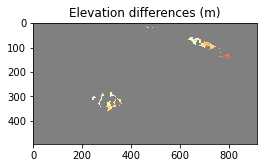

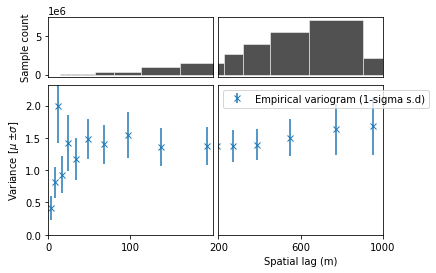

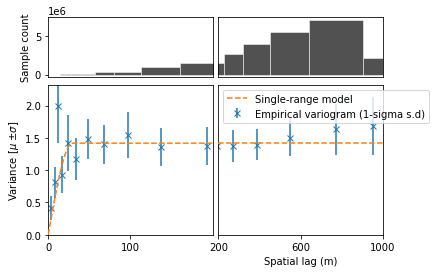

{'Count of all pixels': 173082,
 'Count of stable pixels': 13636,
 'Interval': Interval('1970-09-29', '1977-09-27', closed='right'),
 'Max': 19.656494140625,
 'Mean': -0.44276565313339233,
 'Median': -0.46649169921875,
 'Min': -14.7672119140625,
 'NMAD': 1.124618701171875,
 'Outlier lower limit': -20,
 'Outlier upper limit': 20,
 'Percentage all pixels filtered/removed': 0.0845612736023695,
 'Percentage stable pixels filtered/removed': 0.005397520058351568,
 'RMSE': 1.416018858308105,
 'Range': 29.42485716450877,
 'Sill': 1.4181289726275135,
 'StdDev': 1.3450160026550293,
 'pre-filter': {'Count of all pixels': 189070,
                'Count of stable pixels': 13710,
                'Max': 624.8470458984375,
                'Mean': 0.025638416409492493,
                'Median': -0.4559326171875,
                'Min': -14.7672119140625,
                'NMAD': 1.1312245239257812,
                'RMSE': 8.915485753139983,
                'StdDev': 8.915449142456055}}


Process ForkPoolWorker-114:
Process ForkPoolWorker-112:
Process ForkPoolWorker-110:
Process ForkPoolWorker-113:
Process ForkPoolWorker-98:
Process ForkPoolWorker-108:
Process ForkPoolWorker-106:
Traceback (most recent call last):
Process ForkPoolWorker-96:
Process ForkPoolWorker-95:
Process ForkPoolWorker-101:
Process ForkPoolWorker-103:
Process ForkPoolWorker-94:
Process ForkPoolWorker-109:
Process ForkPoolWorker-111:
Process ForkPoolWorker-107:
Process ForkPoolWorker-99:
Process ForkPoolWorker-97:
Process ForkPoolWorker-92:


KeyboardInterrupt: 

Process ForkPoolWorker-100:
Process ForkPoolWorker-102:
Process ForkPoolWorker-93:
  File "/home/elilouis/.conda/envs/xdem/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-89:
Process ForkPoolWorker-84:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-87:
Process ForkPoolWorker-85:
Traceback (most recent call last):
  File "/home/elilouis/.conda/envs/xdem/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/elilouis/.conda/envs/xdem/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/elilouis/.conda/envs/xdem/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/elilouis/.conda/envs/xdem/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):


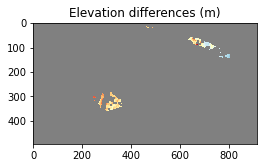

  File "/home/elilouis/.conda/envs/xdem/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/elilouis/.conda/envs/xdem/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-88:
  File "/home/elilouis/.conda/envs/xdem/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/elilouis/.conda/envs/xdem/lib/python3.9/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/elilouis/xdem/xdem/spatialstats.py", line 603, in _wrapper_get_empirical_variogram
    return get_variogram(**argdict)
  File "/home/elilouis/xdem/xdem/spatialstats.py", line 570, in _get_cdist_empirical_variogram
    V = skg.Variogram(M, values=values, normalize=False, fit_method=None, **filtered_var_kwargs)
  File "/home/elilouis/.conda/envs/xdem/lib/python3.9/site-packages/skgstat/Variogram.py", line 349, in __init_

In [41]:
for ddem in demcollection_uncertainty.ddems:
    # try:
    results, figs = uncertainty_analysis(
        ddem,
        gcas_vector,
        subsample = VARIOGRAM_SUBSAMPLE,
        n_variograms = VARIOGRAM_N_VARIOGRAMS,
        xscale_range_split = XSCALE_RANGE_SPLIT,
        parallelism=PARALLELISM,
        maxlag=MAX_LAG
    )
    interval_string = clean_interval_string(ddem.interval)
    figs[0].savefig(os.path.join(plot_output_dir, f"dod_uncertainty_static_areas_{interval_string}.png"))
    figs[1].savefig(os.path.join(plot_output_dir, f"dod_uncertainty_empirical_variogram_{interval_string}.png"))
    figs[2].savefig(os.path.join(plot_output_dir, f"dod_uncertainty_fit_variogram_{interval_string}.png"))
    pprint(results, width=1)
    results_dict[results["Interval"]] = results
    # except Exception as exc:
        # print(f"Failed on ddem: {ddem.interval}")
        # print(exc)

### Analyze all uncertainty results

In [ ]:
results_df = pd.DataFrame(results_dict).transpose().reset_index(drop=True)
results_df['Start Date'] = results_df['Interval'].apply(lambda x: x.left)
results_df['End Date'] = results_df['Interval'].apply(lambda x: x.right)
results_df['NMAD'] = pd.to_numeric(results_df['NMAD'])
results_df['Mean'] = pd.to_numeric(results_df['Mean'])
results_df['RMSE'] = pd.to_numeric(results_df['RMSE'])
results_df['Range'] = pd.to_numeric(results_df['Range'])
results_df['Sill'] = pd.to_numeric(results_df['Sill'])
results_df

In [ ]:
chart = alt.Chart(results_df.drop(columns="Interval")).mark_bar(
    strokeWidth = 3,
    stroke="white",
).encode(
    alt.X("Start Date:T"),
    alt.X2("End Date:T"),
    alt.Y(alt.repeat("row"), type='quantitative'),
).properties(
    # width=200,
    height=150
).repeat(
    row=['NMAD', 'Mean', 'RMSE', 'Range', 'Sill']
)
# chart.save(os.path.join(plot_output_dir, "uncertainty_results.png"), scale_factor=2.0)
display(chart)

In [ ]:
if RUN_LARGERAREA:
    results_df.to_pickle(output_file_largerarea)
else:
    results_df.to_pickle(output_file)
